In [2]:
from PIL import Image
import keras_tuner as kt
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Cropping2D, Input, Rescaling
from tensorflow.keras.applications import ResNet50
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_for_resnet
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
import gc

In [3]:
test_dir = './histopathologic-cancer-detection/test/'
train_dir = './histopathologic-cancer-detection/train/'
train_labels_file = './histopathologic-cancer-detection/train_labels.csv'
test_labels_file = './histopathologic-cancer-detection/sample_submission.csv'

In [4]:
train_labels = pd.read_csv(train_labels_file)
test_labels = pd.read_csv(test_labels_file)

num_train_images = len(os.listdir(train_dir))
num_test_images = len(os.listdir(test_dir))
num_train_labels = train_labels.shape[0]
num_test_labels = test_labels.shape[0]

print(f"Number of training images: {num_train_images}")
print(f"Number of test images: {num_test_images}")
print(f"Number of training labeled images: {num_train_labels}")
print(f"Number of testing labeled images: {num_test_labels}")

Number of training images: 220025
Number of test images: 57458
Number of training labeled images: 220025
Number of testing labeled images: 57458


/var/folders/qb/kg2dkg_s7dj4_4419z7q2fj40000gn/T/ipykernel_41959/2167200006.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=label_counts, x='label', y='proportion', palette=["#76c7c0", "#d62728"])


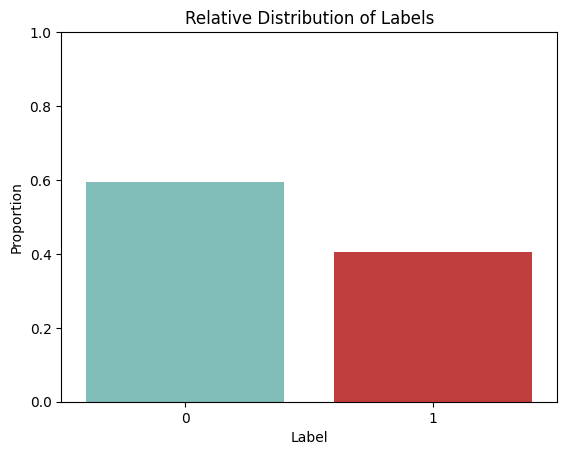

In [5]:
# Count labels in each class
label_counts = train_labels['label'].value_counts(normalize=True).reset_index()
label_counts.columns = ['label', 'proportion']

# Visualize class distribution
sns.barplot(data=label_counts, x='label', y='proportion', palette=["#76c7c0", "#d62728"])

plt.title('Relative Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Proportion')
plt.ylim(0, 1)
plt.show()

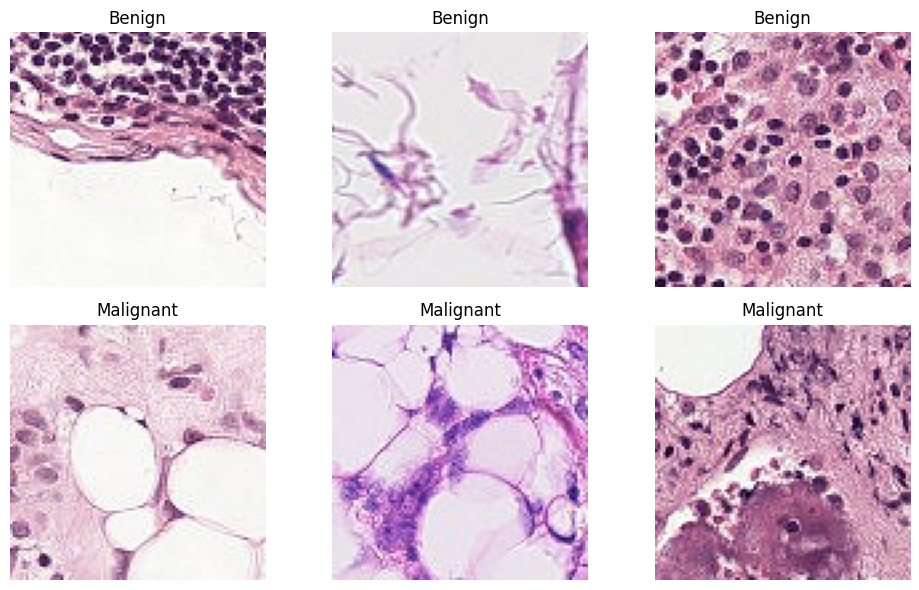

In [6]:
# Visualize benign and malignant samples
benign_samples = train_labels[train_labels["label"] == 0].sample(3)["id"].values
malignant_samples = train_labels[train_labels["label"] == 1].sample(3)["id"].values

fig, axes = plt.subplots(2, 3, figsize=(10,6))

def plot_sample(sample_id, sample_dir, ax, title):
    img_path = os.path.join(sample_dir, sample_id + ".tif")
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(title)

for i, img_id in enumerate(benign_samples):
    ax = axes[0, i]
    plot_sample(img_id, train_dir, ax, 'Benign')

for i, img_id in enumerate(malignant_samples):
    ax = axes[1, i]
    plot_sample(img_id, train_dir, ax, 'Malignant')

plt.tight_layout()
plt.show()

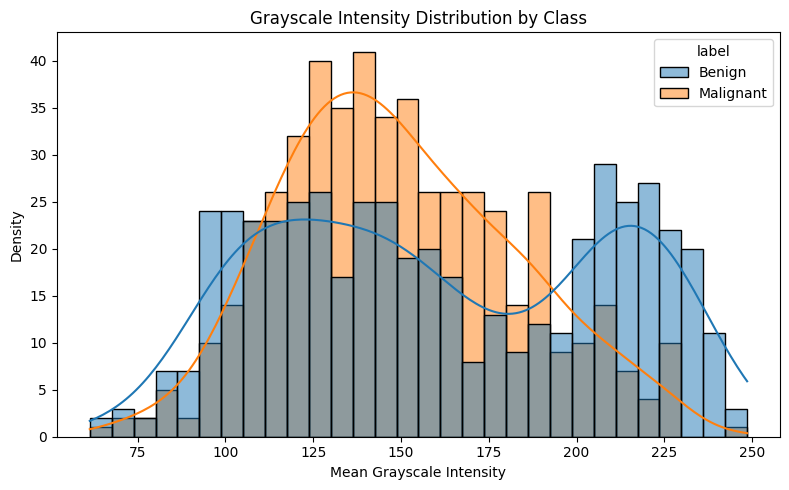

In [7]:
benign_samples = train_labels[train_labels["label"] == 0].sample(500)["id"].values
malignant_samples = train_labels[train_labels["label"] == 1].sample(500)["id"].values

intensities = []

# Function to compute mean grayscale intensity per image
def extract_grayscale_intensity(sample_ids, label_name):
    for img_id in sample_ids:
        img_path = os.path.join(train_dir, img_id + ".tif")
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mean_intensity = np.mean(img)
        intensities.append({'label': label_name, 'intensity': mean_intensity})

# Process samples
extract_grayscale_intensity(benign_samples, 'Benign')
extract_grayscale_intensity(malignant_samples, 'Malignant')

# Create DataFrame for Seaborn
df_gray = pd.DataFrame(intensities)

# Plot
plt.figure(figsize=(8, 5))

sns.histplot(data=df_gray, x='intensity', hue='label', kde=True, common_norm=False, bins=30)

plt.title('Grayscale Intensity Distribution by Class')
plt.xlabel('Mean Grayscale Intensity')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

PreProcessing


In [7]:
missing_values = train_labels.isnull().sum()
print(missing_values)

id       0
label    0
dtype: int64


In [8]:
duplicates = train_labels.duplicated().sum()
print(f"Duplicate entries: {duplicates}")

Duplicate entries: 0


Step 1: Subsample to create a balanced dataset (1k each class). Tried using 10k samples for each class, but it took more than 6 hours, for just one of the models.

In [8]:
benign = train_labels[train_labels.label == 0].sample(1000, random_state=42)
malignant = train_labels[train_labels.label == 1].sample(1000, random_state=42)
balanced_labels = pd.concat([benign, malignant]).sample(frac=1, random_state=42)  # Shuffle

Step 2: Define image loading + preprocessing function

In [4]:
def load_and_preprocess_image(image_id, image_dir=train_dir, target_size=(224, 224)):
    path = os.path.join(image_dir, image_id + '.tif')
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    image = image.astype(np.float32) / 255.0  # Normalize to [0,1]
    return image

Step 3: Load images and labels into arrays

In [11]:
X = np.array([load_and_preprocess_image(iid) for iid in balanced_labels['id']])
y = balanced_labels['label'].values

Step 4: Split into training and validation sets

In [12]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

Model Training

Simple CNN

In [13]:
def build_simple_cnn(hp):
    model = Sequential()

    dropout_rate = hp.Choice('dropout_rate', values=[0.3, 0.5])
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])
    dense_units = hp.Choice('dense_units', values=[64, 128])

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [14]:
# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [15]:
cnn_tuner = kt.RandomSearch(
    build_simple_cnn,
    objective='val_accuracy',
    max_trials=6,
    executions_per_trial=1,
    directory='cnn_tuning',
    project_name='simple_cnn_tuning'
)

# Run tuning
cnn_tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stop], verbose=2)

Reloading Tuner from cnn_tuning/simple_cnn_tuning/tuner0.json


In [16]:
best_cnn_model = cnn_tuner.get_best_models(1)[0]
print("\nBest Model Summary:")
best_cnn_model.summary()



Best Model Summary:


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    11,944,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,963,457 (45.64 MB)

 Trainable params: 11,963,457 (45.64 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Evaluate
val_loss, val_acc = best_cnn_model.evaluate(X_val, y_val)
print(f"\nValidation Accuracy: {val_acc:.4f}")

best_cnn_hps = cnn_tuner.get_best_hyperparameters(num_trials=1)[0]
# List all top hyperparams
print("\nBest Hyperparameters:")
for k, v in best_cnn_hps.values.items():
    print(f"{k}: {v}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.7465 - loss: 0.5533

Validation Accuracy: 0.7725

Best Hyperparameters:
dropout_rate: 0.3
learning_rate: 0.0001
dense_units: 64


Evaluation

In [18]:
print("\nTop Hyperparameter Configurations:")
top_cnn_hps = cnn_tuner.get_best_hyperparameters(num_trials=3)
for i, hp in enumerate(top_cnn_hps):
    print(f"\nTop-{i+1} Hyperparameters:")
    for key, value in hp.values.items():
        print(f"{key}: {value}")


Top Hyperparameter Configurations:

Top-1 Hyperparameters:
dropout_rate: 0.3
learning_rate: 0.0001
dense_units: 64

Top-2 Hyperparameters:
dropout_rate: 0.5
learning_rate: 0.0001
dense_units: 128

Top-3 Hyperparameters:
dropout_rate: 0.5
learning_rate: 0.001
dense_units: 64


In [19]:
cnn_trial_metrics = []
for trial in cnn_tuner.oracle.trials.values():
    hp = trial.hyperparameters.values
    val_accuracy = trial.metrics.get_best_value('val_accuracy')
    cnn_trial_metrics.append({**hp, 'val_accuracy': val_accuracy})

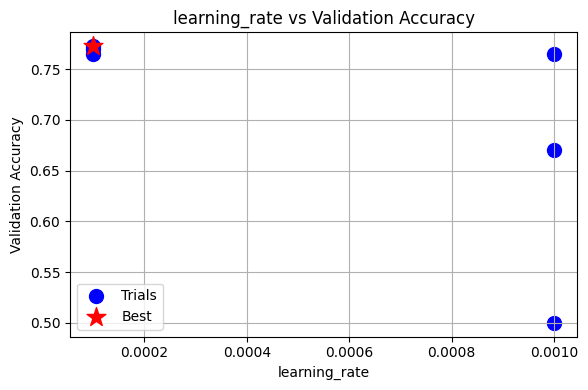

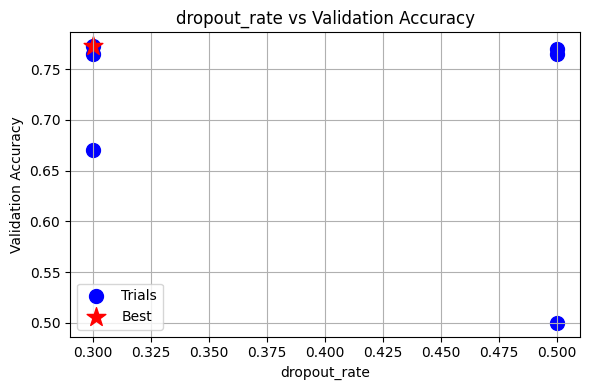

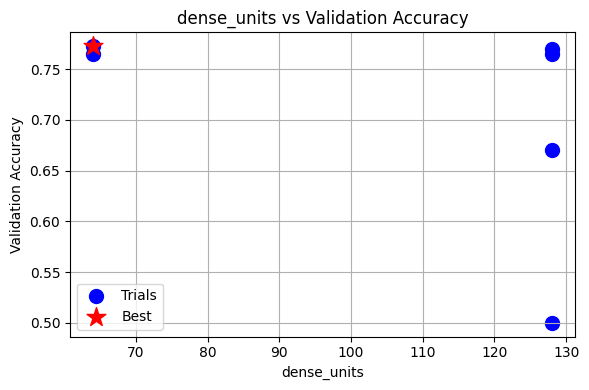

In [20]:
cnn_df = pd.DataFrame(cnn_trial_metrics)
best_cnn = cnn_df[cnn_df['val_accuracy'] == cnn_df['val_accuracy'].max()].iloc[0]

# === Plotting function ===
def plot_hyperparameter(df, param_name, best_value):
    plt.figure(figsize=(6, 4))
    plt.scatter(df[param_name], df['val_accuracy'], s=100, c='blue', label='Trials')
    plt.scatter([best_value], [df['val_accuracy'].max()], s=200, c='red', label='Best', marker='*')
    plt.title(f'{param_name} vs Validation Accuracy')
    plt.xlabel(param_name)
    plt.ylabel('Validation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# === Plots for each hyperparameter ===
plot_hyperparameter(cnn_df, 'learning_rate', best_cnn['learning_rate'])
plot_hyperparameter(cnn_df, 'dropout_rate', best_cnn['dropout_rate'])
plot_hyperparameter(cnn_df, 'dense_units', best_cnn['dense_units'])

Now onto ResNet

In [21]:
# === Load and preprocess images ===
def load_and_preprocess_image_resnet(image_id, image_dir=train_dir, target_size=(224, 224)):
    path = os.path.join(image_dir, image_id + '.tif')
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    image = preprocess_input(image.astype(np.float32))  # ResNet-specific preprocessing
    return image

X = np.array([load_and_preprocess_image_resnet(iid) for iid in balanced_labels['id']])
y = balanced_labels['label'].values

# === Split into train/val ===
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [22]:
# === Define the model using ResNet50 ===
def build_resnet_model(hp):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze the base

    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    dropout_rate = hp.Choice('dropout_rate', [0.3, 0.5])
    dense_units = hp.Choice('dense_units', [64, 128])
    learning_rate = hp.Choice('learning_rate', [1e-3, 1e-4])

    x = Dropout(dropout_rate)(x)
    x = Dense(dense_units, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [23]:
# === Early stopping callback ===
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# === Run Keras Tuner ===
resnet_tuner = kt.RandomSearch(
    build_resnet_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='resnet_tuning',
    project_name='resnet_cancer_detection'
)

resnet_tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stop], verbose=2)

Reloading Tuner from resnet_tuning/resnet_cancer_detection/tuner0.json


In [24]:
# === Show best model and hyperparameters ===
best_resnet_model = resnet_tuner.get_best_models(1)[0]
print("\nBest ResNet Model Summary:")
best_resnet_model.summary()

best_resnet_hps = resnet_tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nBest Hyperparameters:")
for k, v in best_resnet_hps.values.items():
    print(f"{k}: {v}")


Best ResNet Model Summary:


/opt/homebrew/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


Best Hyperparameters:
dropout_rate: 0.5
dense_units: 128
learning_rate: 0.001


In [25]:
# === Trial performance analysis ===
trial_resnet_metrics = []
for trial in resnet_tuner.oracle.trials.values():
    hp = trial.hyperparameters.values
    val_accuracy = trial.metrics.get_best_value('val_accuracy')
    trial_resnet_metrics.append({**hp, 'val_accuracy': val_accuracy})

resnet_df = pd.DataFrame(trial_resnet_metrics)
best_resnet = resnet_df[resnet_df['val_accuracy'] == resnet_df['val_accuracy'].max()].iloc[0]

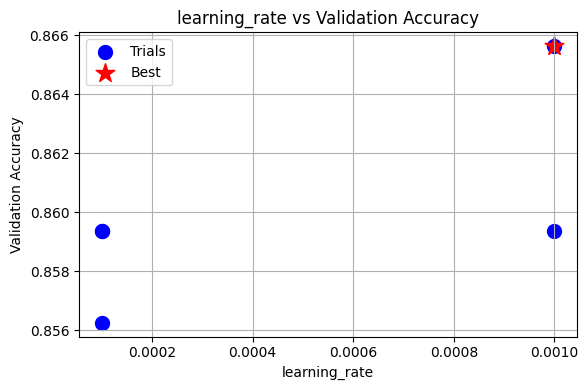

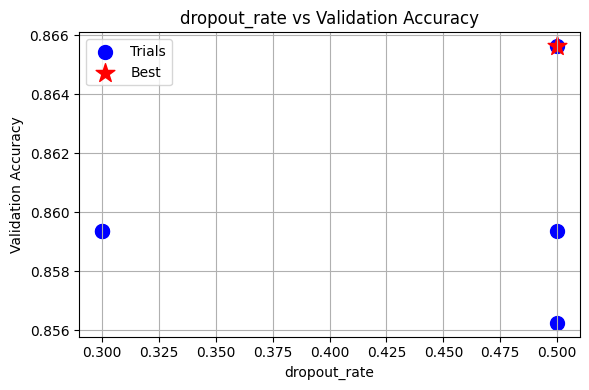

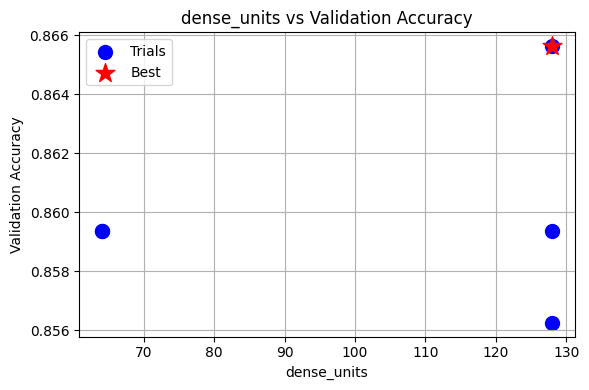

In [26]:
# === Plotting ===
'''def plot_hyperparameter(df, param_name, best_value):
    plt.figure(figsize=(6, 4))
    plt.scatter(df[param_name], df['val_accuracy'], s=100, label='Trials')
    plt.scatter([best_value], [df['val_accuracy'].max()], s=200, c='red', marker='*', label='Best')
    plt.title(f'{param_name} vs Validation Accuracy')
    plt.xlabel(param_name)
    plt.ylabel('Validation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()'''

plot_hyperparameter(resnet_df, 'learning_rate', best_resnet['learning_rate'])
plot_hyperparameter(resnet_df, 'dropout_rate', best_resnet['dropout_rate'])
plot_hyperparameter(resnet_df, 'dense_units', best_resnet['dense_units'])

In [27]:
best_params_for_final_training = {
    'dropout_rate': best_resnet['dropout_rate'],
    'dense_units': best_resnet['dense_units'],
    'learning_rate': best_resnet['learning_rate']
}

In [28]:
def build_final_resnet_model(dropout_rate, dense_units, learning_rate):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze base

    print(f"Dropout Rate: {dropout_rate}")
    print(f"Learning Rate: {learning_rate}")
    print(f"Dense Units: {dense_units}")

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(dense_units, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [29]:
X = np.array([load_and_preprocess_image_resnet(iid) for iid in balanced_labels['id']])
y = balanced_labels['label'].values

# === Split into train/val ===
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [30]:
final_model = build_final_resnet_model(
    dropout_rate=float(best_params_for_final_training['dropout_rate']),
    dense_units=int(best_params_for_final_training['dense_units']),
    learning_rate=float(best_params_for_final_training['learning_rate'])
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    callbacks=[early_stop],
    batch_size=32,
    verbose=2
)

Dropout Rate: 0.5
Learning Rate: 0.001
Dense Units: 128
Epoch 1/50
50/50 - 47s - 949ms/step - accuracy: 0.7331 - loss: 0.5870 - val_accuracy: 0.8200 - val_loss: 0.3977
Epoch 2/50
50/50 - 52s - 1s/step - accuracy: 0.8131 - loss: 0.4187 - val_accuracy: 0.8175 - val_loss: 0.3815
Epoch 3/50
50/50 - 58s - 1s/step - accuracy: 0.8344 - loss: 0.3659 - val_accuracy: 0.8225 - val_loss: 0.3648
Epoch 4/50
50/50 - 58s - 1s/step - accuracy: 0.8519 - loss: 0.3317 - val_accuracy: 0.8250 - val_loss: 0.3980
Epoch 5/50
50/50 - 58s - 1s/step - accuracy: 0.8544 - loss: 0.3289 - val_accuracy: 0.8125 - val_loss: 0.3988
Epoch 6/50
50/50 - 58s - 1s/step - accuracy: 0.8575 - loss: 0.3136 - val_accuracy: 0.8225 - val_loss: 0.4090
Epoch 7/50
50/50 - 59s - 1s/step - accuracy: 0.8625 - loss: 0.3170 - val_accuracy: 0.8400 - val_loss: 0.3481
Epoch 8/50
50/50 - 59s - 1s/step - accuracy: 0.8712 - loss: 0.3041 - val_accuracy: 0.8350 - val_loss: 0.3805
Epoch 9/50
50/50 - 59s - 1s/step - accuracy: 0.8825 - loss: 0.2697 - 

In [31]:
final_model.save("final_resnet_model.h5")

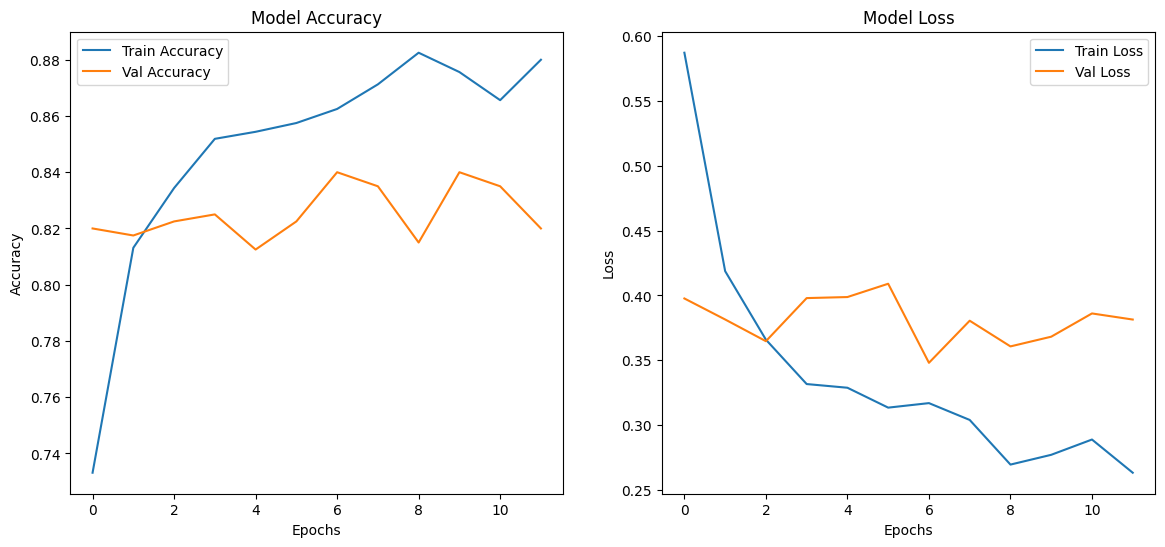

Final Training Accuracy: 0.8800
Final Validation Accuracy: 0.8200
Final Training Loss: 0.2634
Final Validation Loss: 0.3814


In [32]:
# === Extract training history ===
history = history.history  # Assuming you got the history from model.fit()

# Accuracy and Loss over epochs
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot Accuracy
axs[0].plot(history['accuracy'], label='Train Accuracy')
axs[0].plot(history['val_accuracy'], label='Val Accuracy')
axs[0].set_title('Model Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Plot Loss
axs[1].plot(history['loss'], label='Train Loss')
axs[1].plot(history['val_loss'], label='Val Loss')
axs[1].set_title('Model Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.show()

# === Print final metrics ===
final_train_acc = history['accuracy'][-1]
final_val_acc = history['val_accuracy'][-1]
final_train_loss = history['loss'][-1]
final_val_loss = history['val_loss'][-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

output model#############################################

In [35]:
#test_labels.head()
del X_train, X_val, y_train, y_val
gc.collect()

NameError: name 'X_train' is not defined

In [14]:
def tf_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = preprocess_for_resnet(image.astype(np.float32))
    return image

In [11]:
# If needed, convert the 'id' column to include .tif
test_labels['id'] = test_labels['id'].astype(str) + '.tif'

# ImageDataGenerator with ResNet preprocessing
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_for_resnet)

# Create generator from dataframe
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_labels,
    directory=test_dir,
    x_col='id',
    y_col=None,  # No labels for test set
    target_size=(224, 224),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

Found 57458 validated image filenames.


In [15]:
image_paths = [os.path.join(test_dir, f"{img_id}.tif") for img_id in test_labels['id']]

# Create dataset
test_ds = tf.data.Dataset.from_tensor_slices(image_paths)
test_ds = test_ds.map(lambda x: tf_preprocess_image(x), num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

ValueError: in user code:

    File "/var/folders/qb/kg2dkg_s7dj4_4419z7q2fj40000gn/T/ipykernel_62219/2569741568.py", line 5, in None  *
        lambda x: tf_preprocess_image(x)
    File "/var/folders/qb/kg2dkg_s7dj4_4419z7q2fj40000gn/T/ipykernel_62219/3531473718.py", line 4, in tf_preprocess_image  *
        image = tf.image.resize(image, [224, 224])

    ValueError: 'images' contains no shape.


In [9]:
final_model = load_model("final_resnet_model.h5")

In [12]:
y_pred_resnet = final_model.predict(test_generator, verbose=1)
y_pred_resnet = y_pred_resnet.ravel()

/opt/homebrew/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 1709s 951ms/step


In [14]:
# Build submission
submission_resnet_df = pd.DataFrame({
    'id': test_labels['id'],
    'label': y_pred_resnet
})

submission_resnet_df['id'] = submission_resnet_df['id'].str.replace('.tif', '', regex=False)

submission_resnet_df.to_csv('submission_resnet.csv', index=False)